# Behavioral Cloning

Project 3 using keras.

In [1]:
import pandas as pd
import numpy as np
import math
import glob
import os
import csv
import tensorflow as tf
import keras
import random
import cv2
tf.python.control_flow_ops = tf

import PIL
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, BatchNormalization, MaxPooling2D, \
                         Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [2]:
csv_data_fname = 'data/epoch_2/driving_log.csv'
img_location_base = 'data/epoch_2/IMG/'
all_images = glob.glob(os.path.join(img_location_base,'*.jpg'))

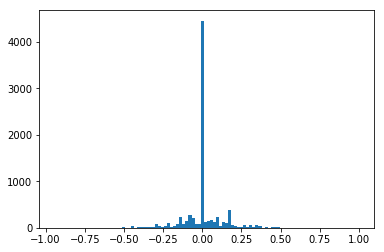

(160, 320, 3)
(8036, 160, 320, 3)


In [3]:
driving_dat = pd.read_csv(csv_data_fname)
driving_dat.head()

plt.hist(driving_dat.iloc[:,3],100)
plt.show()
#load a single image to get dimensions
img = Image.open(os.path.join(img_location_base, os.path.basename(driving_dat.iloc[0,0])))
img_np = np.asarray(img)

img_shape = img_np.shape
print(img_shape)

num_samples = len(driving_dat.iloc[:,3])
print((num_samples,) + img_shape)




[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1457, 3579, 5602, 1220, 1856, 6048, 4347, 2809, 2883]
(8036, 7)
(4175, 7)
center      IMG/center_2016_12_01_13_31_13_584.jpg
left          IMG/left_2016_12_01_13_31_13_584.jpg
right        IMG/right_2016_12_01_13_31_13_584.jpg
steering                                         0
throttle                                         0
brake                                            0
speed                                      1.36211
Name: 8, dtype: object


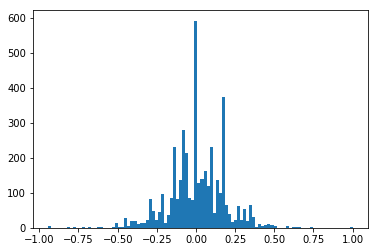

In [4]:
#balance the dataset to have less zeros
num_straight_images = 500
ix = driving_dat[driving_dat.iloc[:,3]==0]
drop_num = len(ix)-num_straight_images
ix_list = ix.index.tolist()
print(ix_list[1:10])
random.shuffle(ix_list)
print(ix_list[1:10])
print(driving_dat.shape)
driving_dat.drop(ix_list[0:drop_num],inplace=True)
print(driving_dat.shape)
print(driving_dat.iloc[0,:])
plt.hist(driving_dat.iloc[:,3],100)
plt.show()
driving_dat.reset_index(drop=True, inplace=True)

In [5]:
l = driving_dat.iloc[:,3].tolist()
print(len(list(filter(lambda x: x < 0,l))))
print(len(list(filter(lambda x: x > 0,l))))
print(len(list(filter(lambda x: x == 0,l))))



1775
1900
500


In [6]:
def randomize_light(img):
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def flip_image(img):
    return np.fliplr(img)

def randomize_sample(img, label):
    img = randomize_light(img)
    if label < 0 or label >0:
      if random.random()<0.5:
        label = -label
        img = flip_image(img)
    
    return (img,label)
     

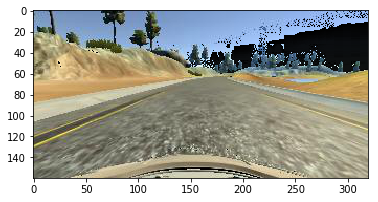

In [7]:
%matplotlib inline
from matplotlib.pyplot import imshow
img = Image.open(os.path.join(img_location_base, os.path.basename(driving_dat.iloc[600,0]))) 
imshow(img)
imshow(randomize_light(np.asarray(img)))

In [8]:
def generate_data(img_location, driving_dat, batch_size):
    
    y = driving_dat.iloc[:,3]
    im_scale = (64,64)
    
    num_samples = len(y)
    img = Image.open(os.path.join(img_location, os.path.basename(driving_dat.iloc[0,0]))) 
    img_np = np.asarray(img)
    img_shape = img_np.shape
    print(img_shape)
    train_shape = (batch_size,) + img_shape
    num_batches = int(np.round(num_samples/batch_size))-1
    print("num batches is " + str(num_batches))
    
    X_train = np.empty(train_shape)
    y_train = np.empty(batch_size)
    while 1:
      total_sample = 0
      for batch in range(1, num_batches):
         for sample in range(0, batch_size-1): 
               rand_sample = random.randint(0,num_samples-1)
               img = Image.open(os.path.join(img_location_base, os.path.basename(driving_dat.iloc[total_sample,0])))
               img_samp, y_samp = randomize_sample(np.asarray(img), y[total_sample])
               X_train[sample, :, :, :] = img_samp
               y_train[sample] = y_samp
               total_sample +=1
         yield (X_train, y_train)


In [9]:
# Build model



nb_filters = 32
nb_pool = 2 # max pool dim
nb_conv = 3
#img_shape = (64,64,3)
print(img_shape)

model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=img_shape))
model.add(Lambda(lambda x: (x/255.0) - 0.5))

model.add(Convolution2D(32,5,5, activation="relu"))
model.add(MaxPooling2D())

model.add(Convolution2D(32,5,5,activation="relu"))
model.add(MaxPooling2D())

model.add(Convolution2D(64,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(128,3,3, activation="relu"))
model.add(MaxPooling2D())
# model.add(Convolution2D(64,3,3, activation="relu"))
# model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='Adam')

(160, 320, 3)


In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 65, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 61, 316, 32)   2432        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 30, 158, 32)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [12]:
batch_size = 128
nb_epoch = 20
samp_per_epoch = batch_size*20

g= generate_data(img_location_base, driving_dat, batch_size)
output= g.__next__()
print(output[0].shape)
print(output[1].shape)
keras.backend.get_session().run(tf.global_variables_initializer())
#history = model.fit(output[0], output[1])
history = model.fit_generator(generate_data(img_location_base, driving_dat, batch_size), 
                             samples_per_epoch=samp_per_epoch, nb_epoch=nb_epoch, pickle_safe=False, max_q_size=1)


model.save('model.h5')


(160, 320, 3)
num batches is 32
(128, 160, 320, 3)
(128,)
Epoch 1/20
(160, 320, 3)
num batches is 32
2560/2560 [==============================] - 10s - loss: 0.0327     

In [ ]:
y=driving_dat.iloc[:,3]

print(y.iloc[0])
i=1
for batch in generate_data(img_location_base, driving_dat, batch_size):
    print(batch[0].shape)
    i = i+1
    if i>50:
        break

In [ ]:
scores = model.evaluate(x_tr, Y_test)

In [ ]:
for metric_i in range(len(model.metrics_names)):
    print(model.metrics_names[metric_i])
    print(model.metrics[metric_i])
    